In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import cv2
import gc
from tqdm import tqdm
from PIL import Image
from glob import glob
%matplotlib inline
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import roc_curve, auc, confusion_matrix

In [2]:
all_xray_df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('..', 'input', 'data', 'images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df['Patient Age'] = all_xray_df['Patient Age'].map(lambda x: int(x))
all_xray_df['Binary Labels'] = all_xray_df['Finding Labels'].map(lambda x: 0.0 if x == 'No Finding' else 1.0)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,Binary Labels
88513,00021926_003.png,Cardiomegaly,3,21926,10,M,AP,2820,2544,0.139,0.139,NaN,../input/data/images_010/images/00021926_003.png,1.0
69947,00017236_029.png,Infiltration,29,17236,46,M,AP,2500,2048,0.168,0.168,NaN,../input/data/images_008/images/00017236_029.png,1.0
85297,00021024_017.png,Atelectasis|Infiltration,17,21024,27,M,AP,3056,2544,0.139,0.139,NaN,../input/data/images_010/images/00021024_017.png,1.0


In [3]:
class my_set(Dataset):
    def __init__(self,Data,Label,transform=None):
        self.images = Data
        self.label = Label
        self.transform = transform
        
    def __getitem__(self, index):
        label = self.label[index]
        temp = cv2.imread(self.images[index])
        temp = np.array(cv2.cvtColor(temp, cv2.COLOR_BGR2RGB))
        #print(self.images[index])
        try:
          temp = (temp * 255).round().astype(np.uint8)
        except:
          print(self.images[index])
        img = Image.fromarray(temp)
        if self.transform:
          img = self.transform(img)
        label = torch.Tensor([label])
        label = label.to(torch.float)
        return img, label
        
    def __len__(self):
        return len(self.images)

my_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),
])

In [4]:
model = models.inception_v3(pretrained=True)
model.fc = nn.Sequential(nn.Linear(2048, 1),
                        nn.Sigmoid())
model.aux_logits = False

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [5]:
print('CUDA:',torch.version.cuda)
device = torch.device("cuda")
model = model.to(device)
print(device)
gc.collect()
torch.cuda.empty_cache()

CUDA: 11.3
cuda


In [6]:
selection = "train" # ~30k images
# selection = "test" # ~400 images 

covid_df = pd.read_csv(f'/kaggle/input/covidx-cxr2/{selection}.txt', sep=' ', header=None, usecols=[1,2], names=['filename', 'label'])
covid_df['path'] = covid_df['filename'].map(lambda x: f"/kaggle/input/covidx-cxr2/{selection}/" + x)
covid_df['Binary Labels'] = covid_df['label'].map(lambda x: 0.0 if x == 'negative' else 1.0)
covid_df

,filename,label,path,Binary Labels
0,ARDSSevere.png,negative,/kaggle/input/covidx-cxr2/train/ARDSSevere.png,0.0
1,acute-respiratory-distress-syndrome-ards-1.jpg,negative,/kaggle/input/covidx-cxr2/train/acute-respirat...,0.0
2,acute-respiratory-distress-syndrome-ards.jpg,negative,/kaggle/input/covidx-cxr2/train/acute-respirat...,0.0
3,ards-secondary-to-tiger-snake-bite.png,negative,/kaggle/input/covidx-cxr2/train/ards-secondary...,0.0
4,pneumocystis-pneumonia-2-PA.png,negative,/kaggle/input/covidx-cxr2/train/pneumocystis-p...,0.0
...,...,...,...,...
29981,55204bb8-89fc-449d-8563-e91654abea9d.png,negative,/kaggle/input/covidx-cxr2/train/55204bb8-89fc-...,0.0
29982,0f4b80b6-fd39-451f-aebf-7cdb1b655c0b.png,negative,/kaggle/input/covidx-cxr2/train/0f4b80b6-fd39-...,0.0
29983,5fb64e85-62ef-4852-8ad1-f799015c8cc3.png,negative,/kaggle/input/covidx-cxr2/train/5fb64e85-62ef-...,0.0
29984,c57ad4fd-3aa8-4ae8-a262-7336360d8265.png,negative,/kaggle/input/covidx-cxr2/train/c57ad4fd-3aa8-...,0.0


In [7]:
def test_covid(model_file, color):
    model.load_state_dict(torch.load(model_file))
    model.eval()
    held_out_disease = "COVID-19"
    print(f"Running testing for {held_out_disease} with model {model_file}")

    images = list(covid_df['path'])
    labels = list(covid_df['Binary Labels'].map(lambda x: [x]))

    test = my_set(images, labels, transform = my_transform)
    test_loader = DataLoader(test, batch_size=16, shuffle=False, num_workers = 2)
    
    test_correct = 0
    test_total = 0
    pred_label = []
    pred_for_roc_curve = []
    for data, target in tqdm(test_loader):
        target = target.squeeze(1)
        data, target = data.to(device), target.to(device)
        out = model(data)
        predicted = (out>0.5).float()
        pred_label.extend(predicted.tolist())
        pred_for_roc_curve.extend(out.tolist())
        test_correct += (predicted == target).sum().item()
        test_total += target.size(0)
        del data
        gc.collect()
        torch.cuda.empty_cache()
    print(test_correct)
    print(test_total)
    print('Testing Accuracy: {}'.format((100 * test_correct / test_total)))
    acu = (100 * test_correct / test_total)
    
    model_confusion_matrix = confusion_matrix(labels, pred_label)
    print("Confusion matrix\n", model_confusion_matrix)
    
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(labels, pred_for_roc_curve)
    c_ax.plot(fpr, tpr, color=color, label = 'COVID-19 AUC:%0.2f'  % (auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    plt.savefig(f"{held_out_disease}.png")
    print("Test done")
    print()

Running testing for COVID-19 with model /kaggle/input/leaving-nothing-out-covid-model/leave_nothing_out.model


100%|██████████| 1875/1875 [15:57<00:00,  1.96it/s] 


22242
29986
Testing Accuracy: 74.17461482024945
Confusion matrix
 [[ 7163  6829]
 [  915 15079]]
Test done



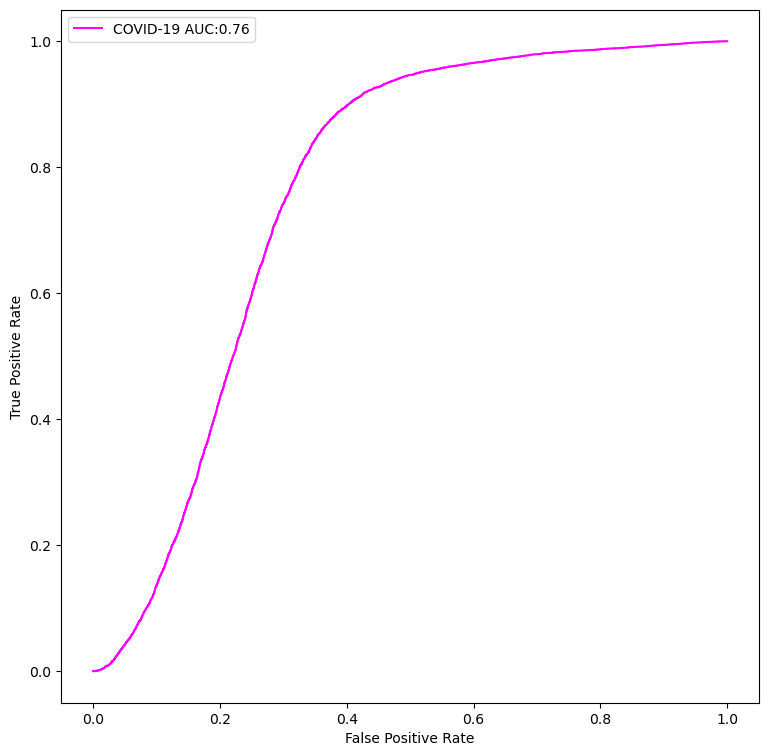

In [8]:
test_covid("/kaggle/input/leaving-nothing-out-covid-model/leave_nothing_out.model", "magenta")